# 1. Set-up
- Import libraries
- Define directories
- Split arrays into single, binary and weird

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as f
from os import listdir

In [2]:
#path to data
path = '/home/puck/Documents/BRP/data' #puck
#path = 'data' #joep

In [64]:
#list of star names
all_stars = np.array(sorted(listdir(path)))

weird_stars = np.array(['2MASSJ11320835-5803199', '2MASSJ12041439-6418516', '2MASSJ12123577-5520273', 
                        '2MASSJ12192161-6454101', '2MASSJ12205449-6457242', '2MASSJ12472196-6808397',
                        '2MASSJ12582559-7028490', '2MASSJ13032904-4723160'])

#weird_stars = np.array(['2MASSJ13032904-4723160'])
binary_stars_og = np.array(['2MASSJ11555771-5254008', '2MASSJ12560830-6926539', '2MASSJ13015435-4249422',
                            '2MASSJ13130714-4537438', 'CD-43_3604', 'CVSO_751', 'Gaia_EDR3_3008386787098934144',
                            'HD_283629', 'HD_284266', 'HD_286179', 'UCAC4_454-011718', 'UCAC4_475-014428', 
                            'UCAC4_495-030196','UCAC4_501-011878'])

binary_stars_close = np.array(['2MASSJ10065573-6352086','2MASSJ11272881-3952572','2MASSJ11445217-6438548',
                               '2MASSJ11452016-5749094','2MASSJ12163007-6711477','2MASSJ12185802-5737191',
                               '2MASSJ12210808-5212226','2MASSJ12234012-5616325','2MASSJ13055087-5304181',
                               '2MASSJ13103245-4817036','2MASSJ13174687-4456534','2MASSJ13335481-6536414',
                               'CoRoT_102718810','Gaia_EDR3_3014970387847972096','IRAS_08131-4432',
                               'RX_J2302.6+0034','UCAC4_127-038351','UCAC4_134-015937','UCAC4_406-011818',
                               'UCAC4_461-018326','UCAC4_482-118442','UCAC4_496-013657','UCAC4_519-042115',
                               'V1319_TAU'])

binary_stars = np.append(binary_stars_og,binary_stars_close)

In [65]:
def mask_arr_stars(arr, star_names):
    mask = np.ones_like(star_names, dtype = bool)
    for i in arr:
        idx = np.where(star_names == i)
        mask[idx] = False
    return mask

In [66]:
single_stars_names = all_stars[(mask_arr_stars(binary_stars, all_stars)*mask_arr_stars(weird_stars, all_stars))]

In [67]:
print('Single stars:',len(single_stars_names),'\nBinary stars:',len(binary_stars),'\nWeird stars:',len(weird_stars) )

Single stars: 64 
Binary stars: 38 
Weird stars: 8


In [68]:
#Show which stars have more than 1 file aka for which star we have more than 1 observation
mask_dates = np.array([len(listdir(f'{path}/{all_stars[i]}'))!= 1 for i in range(len(all_stars))])
more_dates = all_stars[mask_dates]
#print(more_dates)

# 2. Retrieve the data 
- Write a function which retrieves the name of the star and the date of observation
- Write a function to retrieve the data of one star
- Write a function which combines all this data into one array

In [69]:
def star_info(idx, star_names):
    ''' Returns the name of the star and the date of the observation at index idx as a tuple. '''
    return star_names[idx], listdir(f'{path}/{star_names[idx]}')[0]

In [70]:
def star_data(idx, star_names):
    ''' Returns the flux data of the star at the corresponding data at index idx as a 2d numpy array. '''
    name, date = star_info(idx, star_names)
    with f.open(f'{path}/{name}/{date}/B_H/calibration/flux/{name}_{date}_cube_flux_processed_right.fits') as hdul:
        data = hdul[0].data
    return data[0]

In [71]:
def star_data_arr(star_names):
    ''' Returns an array containing all the data if all stars in star_names. '''
    arr = np.empty((len(star_names), 1024, 1024))
    for i in range(len(star_names)):
        arr[i] = star_data(i, star_names)
    return arr

In [72]:
single_stars = star_data_arr(single_stars_names)

# 3. Cutting out central pixels
- Circle of radius 100 pixels around center
- 200 x 200 pixelsaround center

In [73]:
def mask_but_center(arr):
    ''' Masks everything but the area with radius r in a circle around the center. '''
    x = y = np.linspace(-(len(arr))/2, (len(arr))/2, len(arr))
    x_grid, y_grid = np.meshgrid(x, y)
    r_grid = np.sqrt(x_grid**2 + y_grid**2)
    arr[r_grid > 100] = None 
    return arr

def normalize(arr):
    ''' Normalizes the array '''
    arr = np.array(arr,dtype=np.float64)
    return arr/np.nanmax(arr)

def calibration(arr):
    ''' Masks and then normalizes the array. '''
    mask_arr = mask_but_center(arr)
    norm_arr = normalize(mask_arr)
    return norm_arr

In [74]:
#Array with all the single stars but then masked and normalized
single_calib = np.array([calibration(star_data(i, single_stars_names)) for i in range(len(single_stars_names))])

In [75]:
def print_stars(idx, star_names):
    ''' Print the masked and normalised flux image of the star at index idx. '''
    name, date = star_info(idx, star_names)
    star = calibration(star_data(idx, star_names))
    
    plt.subplot(1, 2, 1)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1, 2, 2)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}', y = 0.8)
    plt.show()

# 3. Finding the perfect median star
- Cut out a little square far away from the star
- Calculate the RMS of each little square to determine the noise
- Combine all these RMS in an array and sort them from best to worst
- Write a function that calculates the median of an array of stars
- Write a function 

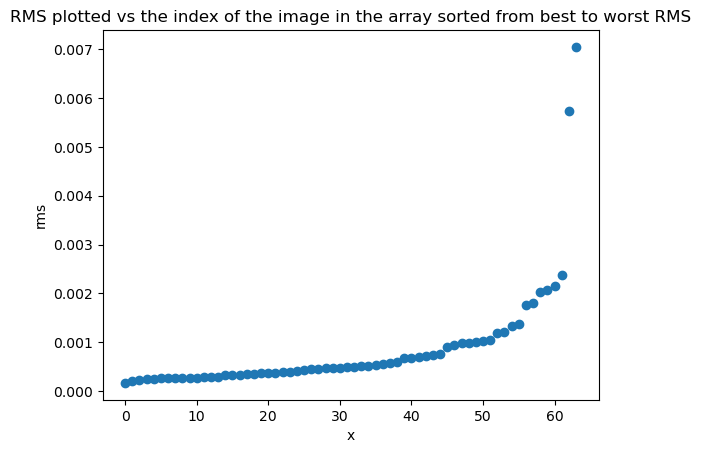

In [81]:
rms = np.std(single_calib[:, 550:570, 450:470], axis = (1, 2)) #gives the rms for every patch in every image
rms_idx = np.argsort(rms) #makes an array with the best index first and the worst index last
rms_sort = rms[rms_idx] #sorts the rms array from best to worst


plt.figure()
plt.title('RMS plotted vs the index of the image in the array sorted from best to worst RMS')
plt.scatter(np.arange(0, len(rms_sort)), rms_sort)
plt.xlabel('x')
plt.ylabel('rms')
plt.show()

In [80]:
#Show that if not normalised the curve looks like this
'''rms = np.std(single_stars[:, 550:570, 450:470], axis = (1, 2)) #gives the rms for every patch in every image
rms_idx = np.argsort(rms) #makes an array with the best index first and the worst index last
rms_sort = rms[rms_idx] #sorts the rms array from best to worst


plt.figure()
plt.title('RMS plotted vs the index of the image in the array sorted from best to worst RMS')
plt.scatter(np.arange(0, len(rms_sort)), rms_sort)
plt.xlabel('x')
plt.ylabel('rms')
plt.show()'''

"rms = np.std(single_stars[:, 550:570, 450:470], axis = (1, 2)) #gives the rms for every patch in every image\nrms_idx = np.argsort(rms) #makes an array with the best index first and the worst index last\nrms_sort = rms[rms_idx] #sorts the rms array from best to worst\n\n\nplt.figure()\nplt.title('RMS plotted vs the index of the image in the array sorted from best to worst RMS')\nplt.scatter(np.arange(0, len(rms_sort)), rms_sort)\nplt.xlabel('x')\nplt.ylabel('rms')\nplt.show()"

In [77]:
single_stars_sort = single_calib[rms_idx] #sorts the single star array from best rms to worst rms
single_stars_names_sort = single_stars_names[rms_idx] #if we ever need to know which star is which

In [78]:
#Here I calculate the rms of the median of the two images and then use the theoretical method
med = np.median(single_stars_sort[rms_idx[0:2]], axis = 0)
print(np.std(med[550:570, 450:470])) #rms of the median image of the two best images

ding = single_stars_sort[rms_idx[0:1],:,:]
ding2 = single_stars_sort[rms_idx[0:2],:,:]

std1 = np.std(ding[0,550:570, 450:470])
std2 = np.std(ding2[0, 550:570, 450:470])

print(np.sqrt(std1**2 + std2**2)/np.sqrt(2)) #combined theoretical rms of the two best images

0.0007432300086560858
0.0010308810664901317


In [116]:
#Make an array in which every ith entry is a median of the images from 0 to i in the array sorted from best to
#worst rms

rms_med_im = np.empty(len(single_stars_sort))
for i in range(len(single_stars_sort)):
    idx_arr = rms_idx[0:i+1]
    med = np.median(single_stars_sort[idx_arr], axis = 0)
    rms_med_im[i] = np.std(med[550:570, 450:470])

In [117]:
print(rms_med_im.shape)

(64,)


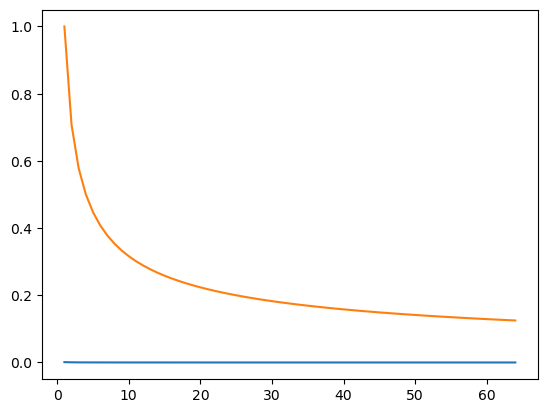

In [121]:
N_keep = np.arange(1, len(rms_arr)+1)
plt.figure()
plt.plot(N_keep, rms_arr/np.sqrt(N_keep))
#plt.plot(N_keep, 1/np.sqrt(N_keep))
plt.show()

In [32]:
rms_arr = np.empty_like(rms_s_s, dtype = float)
for i in range(len(rms_s_s)):
    idx_arr = rms_s_idx[0:i+1]
    med = median_star_arr(single_stars[idx_arr])
    rms_arr[i] = rms_patch(med)
    #plt.figure()
    #plt.title(f'Median with idx [0:{i+1}]')
    #plt.imshow(med)
    #plt.gca().invert_yaxis()
    #plt.xlim(500, 524)
    #plt.ylim(500, 524)
    #plt.colorbar()
    #plt.show()

/tmp/ipykernel_18340/2974407388.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(N_keep, rms_arr/np.sqrt(N_keep))


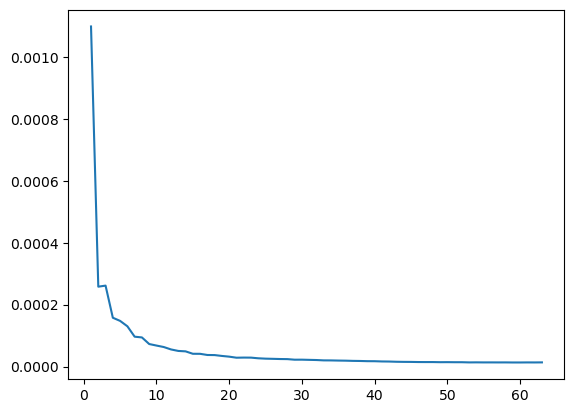

In [33]:
plt.figure()
plt.plot(N_keep, rms_arr/np.sqrt(N_keep))
plt.show()

# 5. Subtract median star from test stars

In [ ]:
def subtract_star(im, med_st):
    ''' Subtract the median star from the image and images the results'''
    im = calibration(im, 100)
    dx = im - med_st
    return dx

In [ ]:
rest = subtract_star(star_data(0, single_stars), med_arr)
name, date = star_info(0, single_stars)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(400, 624)
plt.ylim(400, 624)
plt.show()

In [ ]:
for i in range(len(single_stars)):
    rest = subtract_star(star_data(i, single_stars), med_arr)
    name, date = star_info(i, single_stars)
#     plt.title(f'{name}, {date}')
#     plt.imshow(rest)
#     plt.colorbar()
#     plt.xlim(500, 524)
#     plt.ylim(500, 524)
#     plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rest)
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1,2,2)
    plt.imshow(rest)
    plt.colorbar()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}')
    plt.show()

In [ ]:
subtract_star(star_data(path_sin, 1), med_arr)
name, date = star_info(path_sin, 1)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.show()

# .reg files
1. Want to open them
2. Want to be able to read them
3. Search for key word circle
4. Save x and y coordinate
    - Are all coordinates equally long? --> if not begin next at ,
    - Do not save radius too

In [ ]:
def find_x_y_reg(file, loc_circle, sep):
    ''' Opens the .reg file and returns the x and y coordinate in the file. loc_circle is the number of the line
    where the information on the circle is stored and sep is the thing used for seperating the x and y coord. '''
    with open(file, 'rt') as reg:
        data_reg = reg.readlines()
        data_reg = data_reg[loc_circle]
    
    first, second = data_reg.find(sep), data_reg.rfind(sep)
    return float(data_reg[7:first]), float(data_reg[(first+1):second])

In [ ]:
x, y = find_x_y_reg(f'data/{star}/{date}/{star}_{date}.reg', 3, ',')

In [ ]:
x